In [1]:
#static run with regulators and pv
from pathlib import Path
import PowerSystemClasses as ps
import opendssdirect as dss
import pandas as pd
import numpy as np

def static_sim():
    Dnetwork = ps.DistNetwork()

    components = {'nodes': Path('..', 'network-data', 'nodes.csv'),
              'line_geos': Path('..', 'network-data', 'LineGeometry.csv'),
              'wire_data': Path('..', 'network-data', 'WireData.csv'),
              'CN_data': Path('..', 'network-data', 'CNData.csv'),
              'lines': Path('..', 'network-data', 'lines.csv'),
              'loads': Path('..', 'network-data', 'loads.csv'),
              'xfmrs': Path('..', 'network-data', 'xfmrs.csv'),
              'regs': Path('..', 'network-data', 'regs.csv'),
              'PV': Path('..', 'network-data', 'PV.csv'),
              'circuit': Path('..', 'network-data', 'circuit.csv')}
    
    Dnetwork.add_circuit(components['circuit'])
    Dnetwork.add_nodes(components['nodes'])
    Dnetwork.add_line_geoms(components['line_geos'])
    Dnetwork.add_wiredata(components['wire_data'])
    Dnetwork.add_CNdata(components['CN_data'])
    Dnetwork.add_lines(components['lines'])
    Dnetwork.add_xfmrs(components['xfmrs'])

    Dnetwork.calc_Vbases()

    Dnetwork.add_regulators(components['regs'])
    Dnetwork.add_loads(components['loads'])
    Dnetwork.add_pvsystems(components['PV'])
    

    Dnetwork.calc_electrical_distance()
        
    Dnetwork.check_floating_lines()

    xy_curves = pd.Series({
        'cont': np.array([[0.5, 1],[0.95, 1],[1.05,-1],[1.5, -1]]),
        'deadband': np.array([[0.5, 1],[0.95, 1],[0.98, 0],[1.02,0],[1.05,-1],[1.5, -1]])
        })
    Dnetwork.xy_curves = xy_curves

    Dnetwork.compile_DSS(incl_PV=True)
    sub_meter = ps.Meter(circ_element='Transformer', bus1='src_node', bus2='n0')
    sub_meter.to_DSS()

    Dnetwork.solve_DSS()
    
    Dnetwork.record_DSS_bus_voltages()
    return Dnetwork
    

DN = static_sim()

New XYCurve.cont npts=4 Xarray=(0.5,0.95,1.05,1.5) Yarray=(1.0,1.0,-1.0,-1.0)
New XYCurve.deadband npts=6 Xarray=(0.5,0.95,0.98,1.02,1.05,1.5) Yarray=(1.0,1.0,0.0,0.0,-1.0,-1.0)
New InvControl.invctrl_ mode=voltvar voltage_curvex_ref=rated RefReactivePower=varmax vvc_curve1=cont DeltaQ_factor=0.25


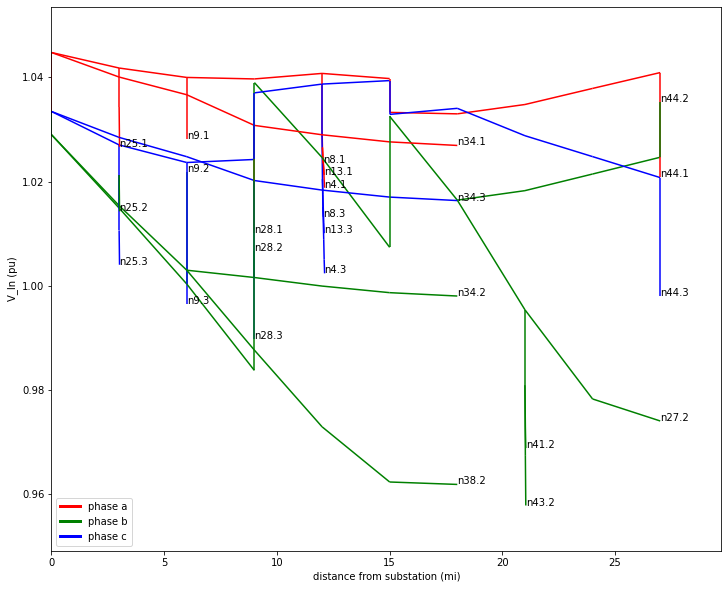

In [2]:
#static bus voltages with regulators and pv
DN.plot_bus_voltages()

In [ ]:
test = {1,2,3}
'.'.join([str(a) for a in test])

'1.2.3'

In [3]:
# 1-week QSTS
import pandas as pd
from pathlib import Path
import PowerSystemClasses as ps
import opendssdirect as dss
import numpy as np

def QSTS():
    Dnetwork = ps.DistNetwork()

    components = {'nodes': Path('..', 'network-data', 'nodes.csv'),
              'line_geos': Path('..', 'network-data', 'LineGeometry.csv'),
              'wire_data': Path('..', 'network-data', 'WireData.csv'),
              'CN_data': Path('..', 'network-data', 'CNData.csv'),
              'lines': Path('..', 'network-data', 'lines.csv'),
              'loads': Path('..', 'network-data', 'loads.csv'),
              'xfmrs': Path('..', 'network-data', 'xfmrs.csv'),
              'regs': Path('..', 'network-data', 'regs.csv'),
              'PV': Path('..', 'network-data', 'PV.csv'),
              'circuit': Path('..', 'network-data', 'circuit.csv')}
    
    Dnetwork.add_circuit(components['circuit'])
    Dnetwork.add_nodes(components['nodes'])
    Dnetwork.add_line_geoms(components['line_geos'])
    Dnetwork.add_wiredata(components['wire_data'])
    Dnetwork.add_CNdata(components['CN_data'])
    Dnetwork.add_lines(components['lines'])
    Dnetwork.add_xfmrs(components['xfmrs'])

    Dnetwork.calc_Vbases()

    Dnetwork.add_pvsystems(components['PV'])
    Dnetwork.add_loads(components['loads'])
    Dnetwork.add_regulators(components['regs'])

    Dnetwork.calc_electrical_distance()
        
    Dnetwork.check_floating_lines()

    loads_path = Path('..', 'network-data', 'load_profiles.csv')
    load_profiles = pd.read_csv(loads_path, parse_dates=['datetime'],index_col='datetime')
    load_profiles = load_profiles.resample('1min').interpolate()
    #load_profiles = load_profiles.iloc[:100,]
    Dnetwork.assign_random_load_profile(load_profiles)

    ghi_path = Path('..', 'network-data', 'boulder_ghi.csv')
    ghi_profile = pd.read_csv(ghi_path, parse_dates=['datetime'],index_col='datetime')
    ghi_profile = ghi_profile.resample('1min').interpolate()
    ghi_profile = ghi_profile.loc[load_profiles.index[0]:load_profiles.index[-1]]
    Dnetwork.assign_all_irradiance(ghi_profile.squeeze('columns'))

    xy_curves = pd.Series({
        'cont': np.array([[0.1, 1],[0.95, 1],[1.05,-1],[1.9, -1]]),
        'deadband': np.array([[0.1, 1],[0.95, 1],[0.98, 0],[1.02,0],[1.05,-1],[1.9, -1]])
        })
    Dnetwork.xy_curves = xy_curves
    Dnetwork.compile_DSS()

    Dnetwork.run_DSS_load_profile(load_profiles.index)

    return Dnetwork

DN_QSTS = QSTS()



New XYCurve.cont npts=4 Xarray=(0.1,0.95,1.05,1.9) Yarray=(1.0,1.0,-1.0,-1.0)
New XYCurve.deadband npts=6 Xarray=(0.1,0.95,0.98,1.02,1.05,1.9) Yarray=(1.0,1.0,0.0,0.0,-1.0,-1.0)
New InvControl.invctrl_ mode=voltvar voltage_curvex_ref=rated RefReactivePower=varmax vvc_curve1=cont DeltaQ_factor=0.25


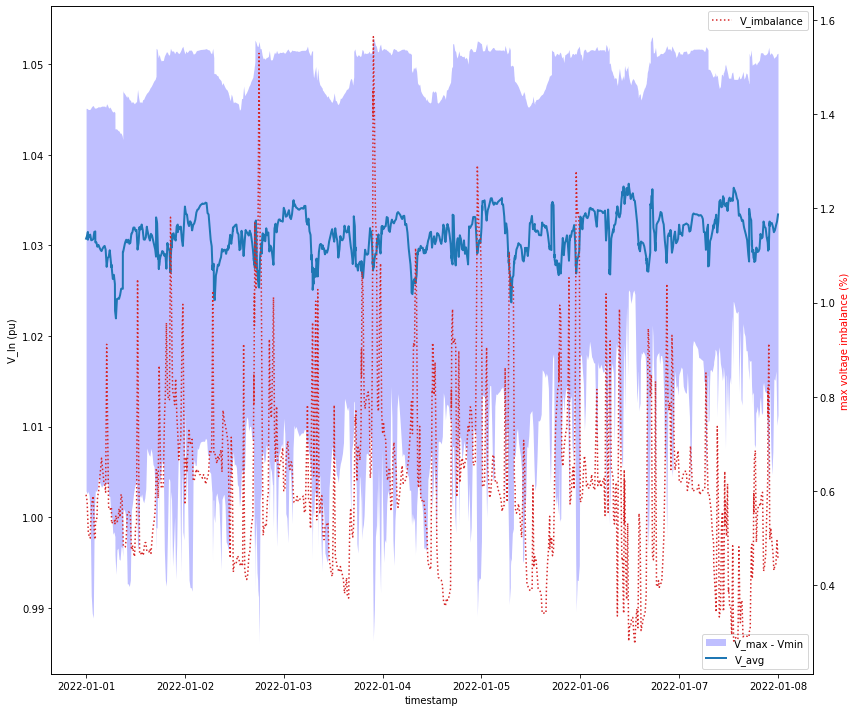

In [4]:
DN_QSTS.plt_ts_voltages()

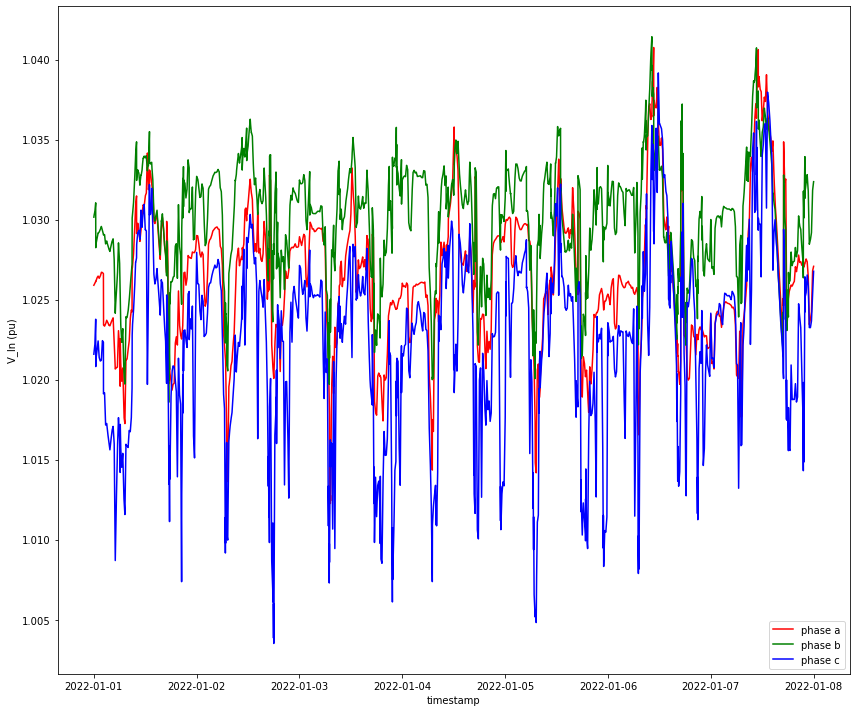

In [5]:
DN_QSTS.plt_bus_ts('n44')
